## Приближение взаимной информации в вершине с помощью нейронных сетей
### Лунин Дмитрий, 25.02.2016

In [1]:
%%capture
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore', module='matplotlib')

In [3]:
import sys
sys.path.append('/home/wrwt/Programming/pygraphmodels')
import graphmodels as gm

Загружаем байесовскую сеть insurance -- в ней достаточно вершин, чтобы задача была нетривиальной, но при этом вычисления не занимают много времени.

In [4]:
dgm = gm.DGM.read('../networks/insurance.bif')

In [141]:
n_nodes = len(dgm.nodes()) # количество вершин
n_nodes

27

In [144]:
from math import factorial
k = 5
# количество вариантов выбора родителей вершины, при условии что их не больше k.
factorial(n_nodes - 1) / factorial(n_nodes - k - 1) / factorial(k)

65780.0

In [5]:
dgm.draw()

/usr/local/lib/python3.4/dist-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/usr/local/lib/python3.4/dist-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


Генерируем данные из байесовской сети.

In [6]:
data = dgm.rvs(size=100000)

Рассмотрим вершину Antilock

In [7]:
fact = dgm.cpd('Antilock')
fact

VehicleYear,MakeModel,Antilock,Prob.
Current,SportsCar,True,0.900
Current,SportsCar,False,0.100
Current,Economy,True,0.001
Current,Economy,False,0.999
Current,FamilySedan,True,0.400
Current,FamilySedan,False,0.600
Current,Luxury,True,0.990
Current,Luxury,False,0.010
Current,SuperLuxury,True,0.990
Current,SuperLuxury,False,0.010


In [122]:
def generate_subset(target, factor, kmin=1, kmax=4, size=1):
    """
    Generate `size` random subsets of parents for node `target` with factor `factor` 
    and calculate discrete mutual information for them.
    Number of parents lies between kmin and kmax
    """
    arguments = list(factor.arguments)
    arguments.remove(target)
    arguments = np.asarray(arguments)
    
    n = np.random.randint(low=kmin, high=kmax+1, size=size)
    result = []
    score = []
    for i, cn in enumerate(n):
        current = np.random.choice(arguments, size=cn, replace=False)
        result.append([1.0 if arg in current else 0.0 for arg in arguments])
        score.append(gm.information.discrete_mutual_information(data[[target]], data[current]))
    return np.vstack(result), np.hstack(score)

In [145]:
args = list(fact.arguments)
args.remove('Antilock')
print(args)
print(len(args))

['GoodStudent', 'Age', 'SocioEcon', 'RiskAversion', 'VehicleYear', 'ThisCarDam', 'RuggedAuto', 'Accident', 'MakeModel', 'DrivQuality', 'Mileage', 'DrivingSkill', 'SeniorTrain', 'ThisCarCost', 'Theft', 'CarValue', 'HomeBase', 'AntiTheft', 'PropCost', 'OtherCarCost', 'OtherCar', 'MedCost', 'Cushioning', 'Airbag', 'ILiCost', 'DrivHist']
26


#### Генерация обучающей выборки для нейросети

In [106]:
X_train, y_train = generate_subset('Antilock', fact, k=5, size=1000)

In [107]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(50, input_dim=26, init='uniform'))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(1, init='uniform'))

In [108]:
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mae',
              optimizer=sgd)

In [109]:
model.fit(X_train, y_train,
          nb_epoch=100,
          batch_size=10)
#score = model.evaluate(X_test, y_test, batch_size=16)

Epoch 1/100
1000/1000 [==============================] - 0s - loss: 0.6391     
Epoch 2/100
1000/1000 [==============================] - 0s - loss: 0.3098     
Epoch 3/100
1000/1000 [==============================] - 0s - loss: 0.1866     
Epoch 4/100
1000/1000 [==============================] - 0s - loss: 0.1568     
Epoch 5/100
1000/1000 [==============================] - 0s - loss: 0.1268     
Epoch 6/100
1000/1000 [==============================] - 0s - loss: 0.1231     
Epoch 7/100
1000/1000 [==============================] - 0s - loss: 0.1116     
Epoch 8/100
1000/1000 [==============================] - 0s - loss: 0.1060     
Epoch 9/100
1000/1000 [==============================] - 0s - loss: 0.0990     
Epoch 10/100
1000/1000 [==============================] - 0s - loss: 0.0961     
Epoch 11/100
1000/1000 [==============================] - 0s - loss: 0.0898     
Epoch 12/100
1000/1000 [==============================] - 0s - loss: 0.0819     
Epoch 13/100
1000/1000 [=============

#### Генерация тестовой выборки

In [159]:
X_test, y_test = generate_subset('Antilock', fact, kmin=3, kmax=5, size=100)

In [160]:
# mean absolute error для тестовой выборки
np.mean(np.abs(model.predict(X_test).flatten() - y_test))

0.021933829997382071

Интересно посмотреть, насколько отличаются оптимальный набор найденный по нейронной сети от реального оптимального набора.

In [161]:
y_test[np.argmax(model.predict(X_test))]

0.28552530949856758

In [162]:
np.max(y_test)

0.35125876850566218

(array([ 30.,  10.,   3.,   0.,  18.,  12.,  15.,   6.,   4.,   2.]),
 array([ 0.00115123,  0.03616199,  0.07117274,  0.10618349,  0.14119425,
         0.176205  ,  0.21121575,  0.24622651,  0.28123726,  0.31624801,
         0.35125877]),
 <a list of 10 Patch objects>)

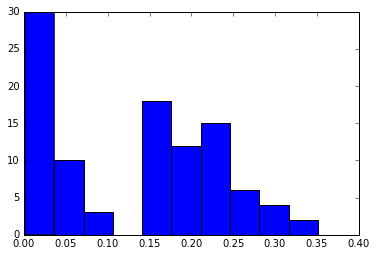

In [163]:
plt.hist(y_test)

Как видим, отличаются они не сильно. Значит, нейронная сеть обучается достаточно хорошему представлению взаимной информации в вершине.